In [1]:
# install the open cv library
!pip install opencv-python

In [2]:
!pip install xgboost

In [3]:
# importing the packages
import pandas as pd
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

## Our aim is to detect open and closed eyes, along with nose and lips.

We are using 2 different cascades for eye detection
<br>
1 for nose detection
<br>
1 for lips detection
<br>
Reference https://stackoverflow.com/questions/48905775/difference-betweeen-haarcascade-eye-and-haarcascade-eye-tree-eyeglasses-xml
https://stackoverflow.com/questions/20801015/recommended-values-for-opencv-detectmultiscale-parameters

In [4]:
# read the face and eye cascade values
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
feature_cascade = cv2.CascadeClassifier('haarcascade_lefteye_2splits.xml')

## Extracting features from Twitter GAN dataset

In [171]:
# eye center formula = (x + int(w/2), y + int(h/2))

positive_feature_count = 0
negative_feature_count = 0

features_list = []
experiments_list = []

# conducting experiment for min_neighbors = 2 to 10 and increasing the sf by 5%
for min_neighbors in tqdm(range(2, 11)):
    # reinitializing the scale_factor
    scale_factor = 1.00
    
    while scale_factor <= 1.2:
        # incrementing the scale_factor
        scale_factor += 0.01
        
        # reinitializing the count metrics
        positive_feature_count = 0
        negative_feature_count = 0
        features_list = []
                
        # extracting the faces and eye coordinates
        for file_path in twitter_gan_faces_list:
            img = cv2.imread(f"{dataset_path + twitter_gan_folder + file_path}", cv2.IMREAD_GRAYSCALE) 

            # resizing the image to same dimension
            img = cv2.resize(img, (200, 200))

            # detect for face
            face_rect = face_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=5)

            # front face found
            if len(face_rect) != 0:
                # detect features
                feature_rect = feature_cascade.detectMultiScale(img, scaleFactor=scale_factor, minNeighbors=min_neighbors)   

                # features found
                if len(feature_rect) != 0:
                    for (x, y, w, h) in eye_rect:
                        # appending the coordinate
                        features_list.append([file_path, x + int(w/2), y + int(h/2)])

                        # increment the left eye positive count
                        positive_feature_count += 1
                else:
                    # increment the negative count
                    negative_feature_count += 1
        
        # creating a df for x and y features
        df = pd.DataFrame(features_list, columns=['file_name', 'feature_x', 'feature_y'])
        file_name = f"facial_features_{scale_factor}_{min_neighbors}_features.csv"
        df.to_csv(f"./results/{file_name}")
        df.drop(df.index , inplace=True)

        experiments_list.append([scale_factor, min_neighbors, positive_feature_count, negative_feature_count, file_name])

f"done with the processing of data...."

100%|████████████████████████████████████████████| 9/9 [46:11<00:00, 307.91s/it]


'done with the processing of data....'

## Plotting the experiments results for TwitterGAN dataset

In [63]:
df = pd.DataFrame(experiments_list, columns=['scale_factor', 'min_neighbors', 'positive_feature_count', 'negative_feature_count', 'file_name'])
df.to_csv("experiments_results.csv")

In [174]:
experiments_df = pd.read_csv("experiments_csv")

In [175]:
experiments_df = experiments_df.drop(columns=['Unnamed: 0'])

In [176]:
experiments_df.head()

,scale_factor,min_neighbors,positive_feature_count,negative_feature_count,file_name
0,1.01,2,1088,0,facial_features_1.01_2_features.csv
1,1.02,2,1084,1,facial_features_1.02_2_features.csv
2,1.03,2,1084,1,facial_features_1.03_2_features.csv
3,1.04,2,1076,3,facial_features_1.04_2_features.csv
4,1.05,2,1076,3,facial_features_1.05_2_features.csv


<AxesSubplot:xlabel='scale_factor', ylabel='positive_feature_count'>

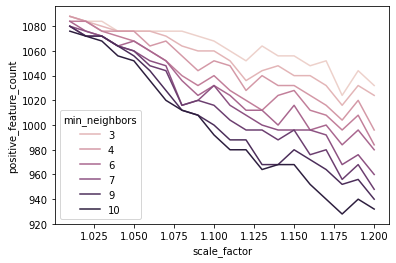

In [179]:
sns.lineplot(data=experiments_df, x=experiments_df["scale_factor"], y=experiments_df["positive_feature_count"], hue=experiments_df["min_neighbors"])

In [181]:
max(experiments_df["positive_feature_count"])

1088

In [182]:
experiments_df.query('positive_feature_count == positive_feature_count.max()')

,scale_factor,min_neighbors,positive_feature_count,negative_feature_count,file_name
0,1.01,2,1088,0,facial_features_1.01_2_features.csv
20,1.01,3,1088,0,facial_features_1.01_3_features.csv
40,1.01,4,1088,0,facial_features_1.01_4_features.csv


## Performing EDA on TwitterGAN dataset

In [185]:
facial_features_df = pd.read_csv("facial_features_1.01_2_features.csv")

In [186]:
facial_features_df.head()

,Unnamed: 0,file_name,feature_x,feature_y
0,0,twitter_GAN_profiles_1673898489_16132647404652...,73,93
1,1,twitter_GAN_profiles_1673898489_16132647404652...,122,93
2,2,twitter_GAN_profiles_1673898489_16132647404652...,93,119
3,3,twitter_GAN_profiles_1673898489_16132647404652...,96,141
4,4,twitter_GAN_profiles_1675459188_14972759585118...,73,93


In [188]:
facial_features_df = facial_features_df.drop(["Unnamed: 0"], axis=1)

In [205]:
facial_features_df.shape
set_s = set()

for i in range(len(facial_features_df)):
    set_s.add((facial_features_df["feature_x"][i], facial_features_df["feature_y"][i]))
set_s

{(73, 93), (93, 119), (96, 141), (122, 93)}

<AxesSubplot:xlabel='feature_x', ylabel='feature_y'>

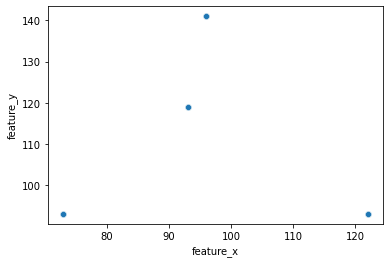

In [194]:
sns.scatterplot(data=facial_features_df, x="feature_x", y="feature_y")

## Getting the FFHQ dataset list

In [3]:
# change these variables according to your file settings
# setting the dataset path
# dataset_path = "../datasets/"
# twitter_gan_folder = "TwitterGAN/"
# random_twitter_folder = "25k_random_twitter_images/"
ffhq_dataset = "../../ffhq_dataset/"
style_gan_folder = "../../styleGAN_25k/"

In [48]:
# twitter faces test_set
ffhq_faces_list = os.listdir(f"{ffhq_dataset}")
f"There are {len(ffhq_faces_list)} images present which are identified as GAN faces"

'There are 52001 images present which are identified as GAN faces'

## FFHQ Dataset Generation
Generation of feature coordinates for FFHQ dataset 

In [60]:
# reinitializing the count metrics
experiments_list = []
positive_feature_count = 0
negative_feature_count = 0
features_list = []

# extracting the faces and eye coordinates
for file_path in tqdm(range(len(ffhq_faces_list))):
    img = cv2.imread(f"{ffhq_dataset + ffhq_faces_list[file_path]}", cv2.IMREAD_GRAYSCALE) 

    # resizing the image to same dimension
    img = cv2.resize(img, (200, 200))

    # detect for face
    face_rect = face_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=5)

    # front face found
    if len(face_rect) != 0:
        # detect features
        feature_rect = feature_cascade.detectMultiScale(img, scaleFactor=1.01, minNeighbors=3)   

        # features found
        if len(feature_rect) != 0:
            for (x, y, w, h) in feature_rect:
                # appending the coordinate
                features_list.append([ffhq_faces_list[file_path], x + int(w/2), y + int(h/2), "No"])

                # increment the left eye positive count
                positive_feature_count += 1
        else:
            # increment the negative count
            negative_feature_count += 1

# creating a df for x and y features
df = pd.DataFrame(features_list, columns=['file_name', 'feature_x', 'feature_y', "is_gan"])
file_name = f"facial_features_true.csv"
df.to_csv(f"{file_name}")
df.drop(df.index , inplace=True)

experiments_list.append([1.01, 3, positive_feature_count, negative_feature_count, file_name])

100%|██████████| 52001/52001 [1:15:02<00:00, 11.55it/s]


## StyleGAN dataset generation
Generation of feature coordinates for StyleGAN dataset

In [50]:
# random twitter profile pictures
style_gan_images_list = os.listdir(f"{style_gan_folder}")
f"There are {len(style_gan_images_list)} images present"

'There are 16687 images present'

In [61]:
# reinitializing the count metrics
# experiments_list = []
positive_feature_count = 0
negative_feature_count = 0
features_list = []

# extracting the faces and eye coordinates
for file_path in tqdm(range(len(style_gan_images_list))):
    img = cv2.imread(f"{style_gan_folder + style_gan_images_list[file_path]}", cv2.IMREAD_GRAYSCALE) 
        
    if img is None:
        continue
    
    # resizing the image to same dimension
    img = cv2.resize(img, (200, 200))

    # detect for face
    face_rect = face_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=5)

    # front face found
    if len(face_rect) != 0:
        # detect features
        feature_rect = feature_cascade.detectMultiScale(img, scaleFactor=1.01, minNeighbors=3)   

        # features found
        if len(feature_rect) != 0:
            for (x, y, w, h) in feature_rect:
                # appending the coordinate
                features_list.append([style_gan_images_list[file_path], x + int(w/2), y + int(h/2), "Yes"])

                # increment the left eye positive count
                positive_feature_count += 1
        else:
            # increment the negative count
            negative_feature_count += 1
            
# creating a df for x and y features
df = pd.DataFrame(features_list, columns=['file_name', 'feature_x', 'feature_y', "is_gan"])
file_name = f"facial_features_false.csv"
df.to_csv(f"{file_name}")
df.drop(df.index , inplace=True)

experiments_list.append([1.01, 3, positive_feature_count, negative_feature_count, file_name])

100%|██████████| 16687/16687 [29:23<00:00,  9.46it/s]


## Viewing the metrics of experiments dataframe

From the dataframe below we can see that for FFHQ dataset we were able to extract around 130000 coordinates which contains eyes, nose and lips after tuning scale factor to 1.01 and min_neighbors to 3. There were 1211 faces which were not identified out of 52000 images. 

For StyleGAN dataset we were able to extract around 60000 coordinates which contains eyes, nose and lips after tuning scale factor to 1.01 and min_neighbors to 3. There were 738 faces which were not identified out of 25000 images.

In [5]:
stylegan_ffhq_experiment_df = pd.read_csv("experiments_results.csv")
stylegan_ffhq_experiment_df

,scale_factor,min_neighbors,positive_feature_count,negative_feature_count,dataset,dataset_size
0,1.01,3,128148,1211,ffhq,52000
1,1.01,3,60378,738,stylegan,25000


## Plotting the scatter plot of true and false images

In [6]:
# reading the csv
features_dataframe = pd.read_csv("data features.csv")

In [7]:
# this dataframe has only 2 dimensions.. expanding the dimensions for x and y features 
features_dataframe

,file_name,feature_x,feature_y,is_gan
0,00000.png,125,89,No
1,00000.png,101,130,No
2,00000.png,73,87,No
3,00001.png,126,91,No
4,00001.png,75,90,No
...,...,...,...,...
188521,099987.png,121,71,Yes
188522,099989.png,125,88,Yes
188523,099989.png,75,88,Yes
188524,099989.png,108,16,Yes


## From the scatter plot we can see that there are 3 patches which are formed and which correspond to left eye, right eye, nose and lips are overlapping.

This is our area of interest and we can focus on the points which are present in that region for detection of GAN faces.

<Axes: xlabel='feature_x', ylabel='feature_y'>

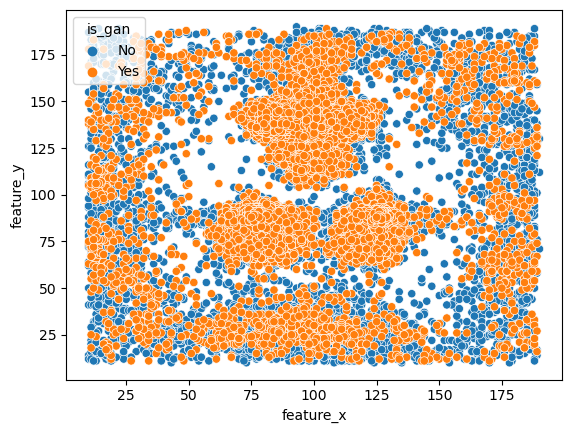

In [9]:
# plotting the scatter plot for all the features
sns.scatterplot(data=features_dataframe, 
                x=features_dataframe["feature_x"], 
                y=features_dataframe["feature_y"], 
                hue=features_dataframe["is_gan"])

## Removing all the other outliers and cleaning the dataset

In [10]:
features_dataframe.shape

(188526, 4)

In [11]:
features_dataframe = features_dataframe[(features_dataframe['feature_x'] >= 50) & (features_dataframe['feature_x'] <= 150)]

In [12]:
features_dataframe.shape

(185526, 4)

## We were able to eliminate around 3000 points after dropping the outliers
Plotting the scatterplot for the new feature dataframe 

<Axes: xlabel='feature_x', ylabel='feature_y'>

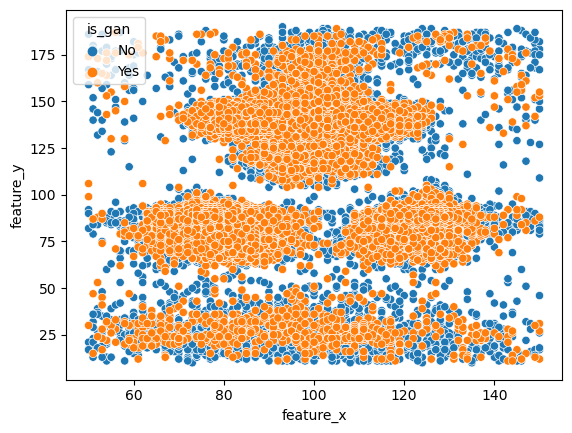

In [13]:
sns.scatterplot(data=features_dataframe, 
                x=features_dataframe["feature_x"], 
                y=features_dataframe["feature_y"], 
                hue=features_dataframe["is_gan"])

In [ ]:
# saving the new csv file after removing the outliers
features_dataframe.to_csv("final_data_features.csv")

## Cleaning and storing the final dataset 

In [8]:
file_names = list(features_dataframe.groupby(["file_name"]).apply(lambda x: x["file_name"].tolist()))
x_coor = list(features_dataframe.groupby(["file_name"]).apply(lambda x: x["feature_x"].tolist()))
y_coor = list(features_dataframe.groupby(["file_name"]).apply(lambda x: x["feature_y"].tolist()))
result = list(features_dataframe.groupby(["file_name"]).apply(lambda x: x["is_gan"].tolist()))

In [9]:
final_df = pd.DataFrame(file_names)
final_df["file_name"] = final_df[0]
final_df = final_df.drop(columns=[0, 1, 2, 3, 4, 5, 6, 7])
final_df["feature_x"] = x_coor
final_df["feature_y"] = y_coor
final_df["is_gan"] = result

In [10]:
final_df

,file_name,feature_x,feature_y,is_gan
0,00000.png,"[125, 101, 73]","[89, 130, 87]","[No, No, No]"
1,000004.png,"[127, 75]","[90, 87]","[Yes, Yes]"
2,00001.png,"[126, 75, 76]","[91, 90, 139]","[No, No, No]"
3,000014.png,"[130, 77]","[89, 91]","[Yes, Yes]"
4,000016.png,"[127, 173, 74]","[90, 61, 91]","[Yes, Yes, Yes]"
...,...,...,...,...
72981,53996.png,"[75, 122, 104]","[89, 89, 141]","[No, No, No]"
72982,53997.png,"[126, 78, 107, 36]","[89, 90, 139, 85]","[No, No, No, No]"
72983,53998.png,"[125, 100, 122]","[89, 156, 76]","[No, No, No]"
72984,53999.png,"[124, 95, 77]","[88, 111, 89]","[No, No, No]"


In [11]:
final_df_x = pd.DataFrame(final_df['feature_x'].to_list(), columns=['feature_x_1','feature_x_2', "feature_x_3", "feature_x_4", "feature_x_5", "feature_x_6", "feature_x_7", "feature_x_8"])
final_df_y = pd.DataFrame(final_df['feature_y'].to_list(), columns=['feature_y_1','feature_y_2', "feature_y_3", "feature_y_4", "feature_y_5", "feature_y_6", "feature_y_7", "feature_y_8"])
final_df_results = pd.DataFrame(final_df['is_gan'].to_list(), columns=['result_1','result_2', "result_3", "result_4", "result_5", "result_6", "result_7", "result_8"])

In [12]:
final_df_x.isna().sum()

feature_x_1        0
feature_x_2     7838
feature_x_3    37756
feature_x_4    60946
feature_x_5    70324
feature_x_6    72581
feature_x_7    72933
feature_x_8    72984
dtype: int64

In [13]:
final_df[["feature_x_1", 'feature_x_2', "feature_x_3", "feature_x_4", "feature_x_5"]] = final_df_x[["feature_x_1", 'feature_x_2', "feature_x_3", "feature_x_4", "feature_x_5"]]
final_df[['feature_y_1','feature_y_2', "feature_y_3", "feature_y_4", "feature_y_5"]] = final_df_y[['feature_y_1','feature_y_2', "feature_y_3", "feature_y_4", "feature_y_5"]]
final_df["is_gan"] = final_df_results['result_1']

In [14]:
final_df.drop(columns=["feature_x", "feature_y"], inplace=True)

In [15]:
final_df.columns

Index(['file_name', 'is_gan', 'feature_x_1', 'feature_x_2', 'feature_x_3',
       'feature_x_4', 'feature_x_5', 'feature_y_1', 'feature_y_2',
       'feature_y_3', 'feature_y_4', 'feature_y_5'],
      dtype='object')

In [16]:
final_df

,file_name,is_gan,feature_x_1,feature_x_2,feature_x_3,feature_x_4,feature_x_5,feature_y_1,feature_y_2,feature_y_3,feature_y_4,feature_y_5
0,00000.png,No,125,101.0,73.0,NaN,NaN,89,130.0,87.0,NaN,NaN
1,000004.png,Yes,127,75.0,NaN,NaN,NaN,90,87.0,NaN,NaN,NaN
2,00001.png,No,126,75.0,76.0,NaN,NaN,91,90.0,139.0,NaN,NaN
3,000014.png,Yes,130,77.0,NaN,NaN,NaN,89,91.0,NaN,NaN,NaN
4,000016.png,Yes,127,173.0,74.0,NaN,NaN,90,61.0,91.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
72981,53996.png,No,75,122.0,104.0,NaN,NaN,89,89.0,141.0,NaN,NaN
72982,53997.png,No,126,78.0,107.0,36.0,NaN,89,90.0,139.0,85.0,NaN
72983,53998.png,No,125,100.0,122.0,NaN,NaN,89,156.0,76.0,NaN,NaN
72984,53999.png,No,124,95.0,77.0,NaN,NaN,88,111.0,89.0,NaN,NaN


In [18]:
final_df.to_csv("final_dataset_containing_5_extracted_features.csv")

## Reading the final dataset

In [4]:
# there are approx 5 features present overall across 75000 images
features_dataframe = pd.read_csv("final_dataset_containing_5_extracted_features.csv")

In [5]:
features_dataframe.shape

(72986, 12)

In [6]:
# viewing the features_dataframe
features_dataframe.head()

,file_name,feature_x_1,feature_x_2,feature_x_3,feature_x_4,feature_x_5,feature_y_1,feature_y_2,feature_y_3,feature_y_4,feature_y_5,is_gan
0,00000.png,125,101.0,73.0,NaN,NaN,89,130.0,87.0,NaN,NaN,No
1,000004.png,127,75.0,NaN,NaN,NaN,90,87.0,NaN,NaN,NaN,Yes
2,00001.png,126,75.0,76.0,NaN,NaN,91,90.0,139.0,NaN,NaN,No
3,000014.png,130,77.0,NaN,NaN,NaN,89,91.0,NaN,NaN,NaN,Yes
4,000016.png,127,173.0,74.0,NaN,NaN,90,61.0,91.0,NaN,NaN,Yes


In [7]:
# performing shuffling on features_dataframe
features_dataframe = features_dataframe.sample(frac=1)
features_dataframe.head()

,file_name,feature_x_1,feature_x_2,feature_x_3,feature_x_4,feature_x_5,feature_y_1,feature_y_2,feature_y_3,feature_y_4,feature_y_5,is_gan
56892,37066.png,76,125.0,116.0,NaN,NaN,90,89.0,144.0,NaN,NaN,No
64246,44792.png,124,NaN,NaN,NaN,NaN,85,NaN,NaN,NaN,NaN,No
60460,40814.png,129,76.0,NaN,NaN,NaN,89,90.0,NaN,NaN,NaN,No
72589,53584.png,129,76.0,79.0,NaN,NaN,89,89.0,142.0,NaN,NaN,No
70509,51389.png,126,75.0,86.0,NaN,NaN,89,89.0,139.0,NaN,NaN,No


In [8]:
features_dataframe = features_dataframe.fillna(-1)

In [9]:
# normalizing the data
is_gan = features_dataframe["is_gan"] 
features_dataframe.drop(columns=["file_name", "is_gan"], inplace=True)

In [10]:
standard_scalar = StandardScaler()
features_dataframe = standard_scalar.fit_transform(features_dataframe)
features_dataframe = pd.DataFrame(features_dataframe)
features_dataframe

,0,1,2,3,4,5,6,7,8,9
0,-1.277176,1.011883,1.399704,-0.432465,-0.189726,-0.188229,0.127754,1.475447,-0.420531,-0.183362
1,0.670618,-2.295293,-0.923653,-0.432465,-0.189726,-0.492777,-2.452038,-0.899031,-0.420531,-0.183362
2,0.873513,-0.274241,-0.923653,-0.432465,-0.189726,-0.249139,0.156418,-0.899031,-0.420531,-0.183362
3,0.873513,-0.274241,0.664967,-0.432465,-0.189726,-0.249139,0.127754,1.442696,-0.420531,-0.183362
4,0.751776,-0.300489,0.803972,-0.432465,-0.189726,-0.249139,0.127754,1.393569,-0.420531,-0.183362
...,...,...,...,...,...,...,...,...,...,...
72981,0.792355,-0.247994,1.081980,-0.432465,-0.189726,-0.249139,0.127754,1.459072,-0.420531,-0.183362
72982,0.711197,-0.221746,-0.923653,-0.432465,-0.189726,-0.188229,0.127754,-0.899031,-0.420531,-0.183362
72983,-1.236597,1.038130,-0.923653,-0.432465,-0.189726,-0.188229,0.127754,-0.899031,-0.420531,-0.183362
72984,-1.317755,1.064378,-0.923653,-0.432465,-0.189726,-0.249139,0.099089,-0.899031,-0.420531,-0.183362


In [11]:
features_dataframe["is_gan"] = is_gan
features_dataframe["is_gan"] = features_dataframe["is_gan"].map(dict(Yes=1, No=0))
features_dataframe

,0,1,2,3,4,5,6,7,8,9,is_gan
0,-1.277176,1.011883,1.399704,-0.432465,-0.189726,-0.188229,0.127754,1.475447,-0.420531,-0.183362,0
1,0.670618,-2.295293,-0.923653,-0.432465,-0.189726,-0.492777,-2.452038,-0.899031,-0.420531,-0.183362,1
2,0.873513,-0.274241,-0.923653,-0.432465,-0.189726,-0.249139,0.156418,-0.899031,-0.420531,-0.183362,0
3,0.873513,-0.274241,0.664967,-0.432465,-0.189726,-0.249139,0.127754,1.442696,-0.420531,-0.183362,1
4,0.751776,-0.300489,0.803972,-0.432465,-0.189726,-0.249139,0.127754,1.393569,-0.420531,-0.183362,1
...,...,...,...,...,...,...,...,...,...,...,...
72981,0.792355,-0.247994,1.081980,-0.432465,-0.189726,-0.249139,0.127754,1.459072,-0.420531,-0.183362,0
72982,0.711197,-0.221746,-0.923653,-0.432465,-0.189726,-0.188229,0.127754,-0.899031,-0.420531,-0.183362,0
72983,-1.236597,1.038130,-0.923653,-0.432465,-0.189726,-0.188229,0.127754,-0.899031,-0.420531,-0.183362,0
72984,-1.317755,1.064378,-0.923653,-0.432465,-0.189726,-0.249139,0.099089,-0.899031,-0.420531,-0.183362,0


In [12]:
features_dataframe.isna().sum()

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
is_gan    0
dtype: int64

## Creating the train and test set 

In [13]:
x = features_dataframe
y = features_dataframe["is_gan"]
x.drop(columns=["is_gan"], inplace=True)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

In [15]:
f"Shape of training data = {x_train.shape[0]} and testing data = {x_test.shape[0]}"

'Shape of training data = 51090 and testing data = 21896'

# Baseline Models

## Applying Logistic Regression Model

In [16]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

LogisticRegression()

In [17]:
logit_predictions = logisticRegr.predict(x_test)

In [18]:
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

0.6808549506759225


In [19]:
cm = metrics.confusion_matrix(y_test, logit_predictions)
print(f"The confusion matrix for Logistic Regression is given below: \n {cm}")

The confusion matrix for Logistic Regression is given below: 
 [[14908     0]
 [ 6988     0]]


In [20]:
logit_precision = precision_score(y_test, logit_predictions, average='weighted', labels=np.unique(logit_predictions))
logit_precision

0.6808549506759225

In [21]:
logit_recall = recall_score(y_test, logit_predictions, average='weighted', labels=np.unique(logit_predictions))
logit_recall

1.0

In [22]:
logit_f1 = f1_score(y_test, logit_predictions, average='weighted', labels=np.unique(logit_predictions))
logit_f1

0.8101293337680686

## Applying Decision Tree Classifier Model

In [66]:
dt_clf = DecisionTreeClassifier(max_depth=10, random_state = 42)
dt_clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [67]:
dt_predictions = dt_clf.predict(x_test)

In [68]:
# Use score method to get accuracy of model
score = dt_clf.score(x_test, y_test)
print(score)

0.6794848374132262


In [69]:
cm = metrics.confusion_matrix(y_test, dt_predictions)
print(f"The confusion matrix for Decision Tree is given below: \n {cm}")

The confusion matrix for Decision Tree is given below: 
 [[14835    73]
 [ 6945    43]]


In [70]:
dt_precision = precision_score(y_test, dt_predictions, average='weighted', labels=np.unique(logit_predictions))
dt_precision

0.681129476584022

In [71]:
dt_recall = recall_score(y_test, dt_predictions, average='weighted', labels=np.unique(logit_predictions))
dt_recall

0.9951033002414811

In [72]:
dt_f1 = f1_score(y_test, dt_predictions, average='weighted', labels=np.unique(logit_predictions))
dt_f1

0.808711295246402

## Applying Random Forest Classifier Model

In [73]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=10, n_estimators=50, oob_score=True)
classifier_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1, oob_score=True,
                       random_state=42)

In [74]:
rf_predictions = classifier_rf.predict(x_test)

In [75]:
# Use score method to get accuracy of model
score = classifier_rf.score(x_test, y_test)
print(score)

0.6807636097917428


In [76]:
cm = metrics.confusion_matrix(y_test, rf_predictions)
print(f"The confusion matrix for Random Forest Regression is given below: \n {cm}")

The confusion matrix for Random Forest Regression is given below: 
 [[14903     5]
 [ 6985     3]]


In [77]:
rf_precision = precision_score(y_test, rf_predictions, average='weighted', labels=np.unique(logit_predictions))
rf_precision

0.6808753654970761

In [78]:
rf_recall = recall_score(y_test, rf_predictions, average='weighted', labels=np.unique(logit_predictions))
rf_recall

0.9996646096055809

In [79]:
rf_f1 = f1_score(y_test, rf_predictions, average='weighted', labels=np.unique(logit_predictions))
rf_f1

0.810033699315143

## Applying KNN Classifier Model

In [80]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=211)
knn_classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=211)

In [81]:
knn_predictions = knn_classifier.predict(x_test)

In [82]:
# Use score method to get accuracy of model
score = knn_classifier.score(x_test, y_test)
print(score)

0.6808549506759225


In [83]:
cm = metrics.confusion_matrix(y_test, rf_predictions)
print(f"The confusion matrix for KNN Classifier is given below: \n {cm}")

The confusion matrix for KNN Classifier is given below: 
 [[14903     5]
 [ 6985     3]]


In [84]:
knn_precision = precision_score(y_test, knn_predictions, average='weighted', labels=np.unique(logit_predictions))
knn_precision

0.6808549506759225

In [85]:
knn_recall = recall_score(y_test, knn_predictions, average='weighted', labels=np.unique(logit_predictions))
knn_recall

1.0

In [86]:
knn_f1 = f1_score(y_test, knn_predictions, average='weighted', labels=np.unique(logit_predictions))
knn_f1

0.8101293337680686

## Applying AdaBoost Classification model

In [87]:
adaboostclf = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)
adaboostclf.fit(x_train, y_train)

AdaBoostClassifier(learning_rate=1, random_state=0)

In [88]:
abc_predictions = adaboostclf.predict(x_test)

In [89]:
accuracy_score(y_test, abc_predictions)

0.680672268907563

In [90]:
cm = metrics.confusion_matrix(y_test, abc_predictions)
print(f"The confusion matrix for AdaBoost Classifier is given below: \n {cm}")

The confusion matrix for AdaBoost Classifier is given below: 
 [[14900     8]
 [ 6984     4]]


In [91]:
abc_precision = precision_score(y_test, abc_predictions, average='weighted', labels=np.unique(logit_predictions))
abc_precision

0.6808627307622008

In [92]:
abc_recall = recall_score(y_test, abc_predictions, average='weighted', labels=np.unique(logit_predictions))
abc_recall

0.9994633753689295

In [93]:
abc_f1 = f1_score(y_test, abc_predictions, average='weighted', labels=np.unique(logit_predictions))
abc_f1

0.8099586866710156

## Applying Support Vector Classifier Model

In [316]:
SVCClf = SVC(kernel='linear', gamma='scale', shrinking=False)
SVCClf.fit(x_train, y_train)

SVC(kernel='linear', shrinking=False)

In [317]:
svm_predictions = SVCClf.predict(x_test)

In [318]:
# Use score method to get accuracy of model
score = SVCClf.score(x_test, y_test)
print(score)

0.6808549506759225


In [319]:
cm = metrics.confusion_matrix(y_test, rf_predictions)
print(f"The confusion matrix for SV Classifier is given below: \n {cm}")

The confusion matrix for SV Classifier is given below: 
 [[14850    58]
 [ 6958    30]]


In [320]:
SVC_precision = precision_score(y_test, svm_predictions, average='weighted', labels=np.unique(logit_predictions))
SVC_precision

0.6808549506759225

In [321]:
SVC_recall = recall_score(y_test, svm_predictions, average='weighted', labels=np.unique(logit_predictions))
SVC_recall

1.0

In [322]:
SVC_f1 = f1_score(y_test, svm_predictions, average='weighted', labels=np.unique(logit_predictions))
SVC_f1

0.8101293337680686

In [323]:
# storing the svm model
filename = 'svc_model_final.pkl'
pickle.dump(SVCClf, open(filename, 'wb'))

## Applying the CatBoost Model

In [94]:
!pip install catboost

In [95]:
!pip install ipywidgets

In [96]:
from catboost import CatBoostClassifier

In [97]:
x_cat = features_dataframe
y_cat = is_gan

In [98]:
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_cat, y_cat, test_size=0.30, random_state=0)

In [99]:
f"Shape of training data = {x_train_cat.shape[0]} and testing data = {x_test_cat.shape[0]}"

'Shape of training data = 51090 and testing data = 21896'

In [129]:
model = CatBoostClassifier()

In [130]:
model.fit(x_train_cat, y_train_cat, verbose=True)

Learning rate set to 0.055258
0:	learn: 0.6860694	total: 17.1ms	remaining: 17.1s
1:	learn: 0.6797460	total: 33.5ms	remaining: 16.7s
2:	learn: 0.6741068	total: 48.7ms	remaining: 16.2s
3:	learn: 0.6690288	total: 63.5ms	remaining: 15.8s
4:	learn: 0.6645297	total: 78.7ms	remaining: 15.7s
5:	learn: 0.6605153	total: 93.6ms	remaining: 15.5s
6:	learn: 0.6569584	total: 108ms	remaining: 15.4s
7:	learn: 0.6538056	total: 122ms	remaining: 15.2s
8:	learn: 0.6509508	total: 136ms	remaining: 15s
9:	learn: 0.6484415	total: 149ms	remaining: 14.7s
10:	learn: 0.6462047	total: 162ms	remaining: 14.6s
11:	learn: 0.6442177	total: 176ms	remaining: 14.5s
12:	learn: 0.6423920	total: 189ms	remaining: 14.3s
13:	learn: 0.6407885	total: 201ms	remaining: 14.2s
14:	learn: 0.6393633	total: 217ms	remaining: 14.3s
15:	learn: 0.6380744	total: 231ms	remaining: 14.2s
16:	learn: 0.6369327	total: 243ms	remaining: 14.1s
17:	learn: 0.6359223	total: 255ms	remaining: 13.9s
18:	learn: 0.6349611	total: 266ms	remaining: 13.7s
19:	lea

175:	learn: 0.6184964	total: 1.64s	remaining: 7.69s
176:	learn: 0.6184633	total: 1.65s	remaining: 7.67s
177:	learn: 0.6184214	total: 1.66s	remaining: 7.66s
178:	learn: 0.6183787	total: 1.67s	remaining: 7.65s
179:	learn: 0.6183412	total: 1.67s	remaining: 7.63s
180:	learn: 0.6183128	total: 1.68s	remaining: 7.61s
181:	learn: 0.6182684	total: 1.69s	remaining: 7.59s
182:	learn: 0.6181983	total: 1.7s	remaining: 7.57s
183:	learn: 0.6181382	total: 1.7s	remaining: 7.55s
184:	learn: 0.6180607	total: 1.71s	remaining: 7.53s
185:	learn: 0.6180001	total: 1.72s	remaining: 7.51s
186:	learn: 0.6179189	total: 1.72s	remaining: 7.5s
187:	learn: 0.6178757	total: 1.73s	remaining: 7.48s
188:	learn: 0.6178460	total: 1.74s	remaining: 7.46s
189:	learn: 0.6177876	total: 1.75s	remaining: 7.44s
190:	learn: 0.6177484	total: 1.75s	remaining: 7.42s
191:	learn: 0.6177147	total: 1.76s	remaining: 7.4s
192:	learn: 0.6176535	total: 1.77s	remaining: 7.39s
193:	learn: 0.6175739	total: 1.77s	remaining: 7.37s
194:	learn: 0.61

344:	learn: 0.6090847	total: 2.88s	remaining: 5.46s
345:	learn: 0.6090442	total: 2.89s	remaining: 5.46s
346:	learn: 0.6090033	total: 2.89s	remaining: 5.45s
347:	learn: 0.6089677	total: 2.9s	remaining: 5.44s
348:	learn: 0.6089095	total: 2.91s	remaining: 5.43s
349:	learn: 0.6088516	total: 2.92s	remaining: 5.42s
350:	learn: 0.6088264	total: 2.92s	remaining: 5.41s
351:	learn: 0.6087903	total: 2.93s	remaining: 5.39s
352:	learn: 0.6087539	total: 2.94s	remaining: 5.38s
353:	learn: 0.6087256	total: 2.95s	remaining: 5.38s
354:	learn: 0.6086695	total: 2.96s	remaining: 5.37s
355:	learn: 0.6086172	total: 2.96s	remaining: 5.36s
356:	learn: 0.6085890	total: 2.98s	remaining: 5.36s
357:	learn: 0.6085262	total: 2.99s	remaining: 5.36s
358:	learn: 0.6084750	total: 3s	remaining: 5.35s
359:	learn: 0.6084462	total: 3.01s	remaining: 5.35s
360:	learn: 0.6083947	total: 3.02s	remaining: 5.34s
361:	learn: 0.6083578	total: 3.02s	remaining: 5.33s
362:	learn: 0.6083179	total: 3.03s	remaining: 5.32s
363:	learn: 0.60

526:	learn: 0.6017742	total: 4.36s	remaining: 3.91s
527:	learn: 0.6017481	total: 4.37s	remaining: 3.91s
528:	learn: 0.6016916	total: 4.38s	remaining: 3.9s
529:	learn: 0.6016587	total: 4.39s	remaining: 3.89s
530:	learn: 0.6015983	total: 4.39s	remaining: 3.88s
531:	learn: 0.6015540	total: 4.4s	remaining: 3.87s
532:	learn: 0.6015066	total: 4.41s	remaining: 3.86s
533:	learn: 0.6014628	total: 4.42s	remaining: 3.85s
534:	learn: 0.6014432	total: 4.42s	remaining: 3.84s
535:	learn: 0.6014166	total: 4.43s	remaining: 3.83s
536:	learn: 0.6013814	total: 4.44s	remaining: 3.83s
537:	learn: 0.6013455	total: 4.45s	remaining: 3.82s
538:	learn: 0.6012975	total: 4.45s	remaining: 3.81s
539:	learn: 0.6012517	total: 4.46s	remaining: 3.8s
540:	learn: 0.6012185	total: 4.47s	remaining: 3.79s
541:	learn: 0.6011626	total: 4.47s	remaining: 3.78s
542:	learn: 0.6011145	total: 4.48s	remaining: 3.77s
543:	learn: 0.6010596	total: 4.49s	remaining: 3.76s
544:	learn: 0.6010199	total: 4.5s	remaining: 3.75s
545:	learn: 0.60

699:	learn: 0.5960431	total: 5.62s	remaining: 2.41s
700:	learn: 0.5960166	total: 5.63s	remaining: 2.4s
701:	learn: 0.5959845	total: 5.64s	remaining: 2.39s
702:	learn: 0.5959603	total: 5.65s	remaining: 2.38s
703:	learn: 0.5959170	total: 5.65s	remaining: 2.38s
704:	learn: 0.5958736	total: 5.66s	remaining: 2.37s
705:	learn: 0.5958473	total: 5.67s	remaining: 2.36s
706:	learn: 0.5958011	total: 5.67s	remaining: 2.35s
707:	learn: 0.5957733	total: 5.68s	remaining: 2.34s
708:	learn: 0.5957506	total: 5.69s	remaining: 2.33s
709:	learn: 0.5957009	total: 5.7s	remaining: 2.33s
710:	learn: 0.5956717	total: 5.71s	remaining: 2.32s
711:	learn: 0.5956374	total: 5.72s	remaining: 2.31s
712:	learn: 0.5956166	total: 5.72s	remaining: 2.3s
713:	learn: 0.5955642	total: 5.73s	remaining: 2.3s
714:	learn: 0.5955397	total: 5.74s	remaining: 2.29s
715:	learn: 0.5955119	total: 5.75s	remaining: 2.28s
716:	learn: 0.5954758	total: 5.76s	remaining: 2.27s
717:	learn: 0.5954202	total: 5.76s	remaining: 2.26s
718:	learn: 0.59

866:	learn: 0.5910912	total: 6.84s	remaining: 1.05s
867:	learn: 0.5910735	total: 6.85s	remaining: 1.04s
868:	learn: 0.5910453	total: 6.86s	remaining: 1.03s
869:	learn: 0.5910211	total: 6.86s	remaining: 1.02s
870:	learn: 0.5909862	total: 6.87s	remaining: 1.02s
871:	learn: 0.5909519	total: 6.88s	remaining: 1.01s
872:	learn: 0.5909237	total: 6.88s	remaining: 1s
873:	learn: 0.5909123	total: 6.89s	remaining: 994ms
874:	learn: 0.5908936	total: 6.9s	remaining: 986ms
875:	learn: 0.5908599	total: 6.91s	remaining: 978ms
876:	learn: 0.5908383	total: 6.91s	remaining: 970ms
877:	learn: 0.5908155	total: 6.92s	remaining: 962ms
878:	learn: 0.5907863	total: 6.93s	remaining: 954ms
879:	learn: 0.5907687	total: 6.93s	remaining: 946ms
880:	learn: 0.5907317	total: 6.94s	remaining: 938ms
881:	learn: 0.5907148	total: 6.95s	remaining: 930ms
882:	learn: 0.5906546	total: 6.96s	remaining: 922ms
883:	learn: 0.5906354	total: 6.96s	remaining: 914ms
884:	learn: 0.5906202	total: 6.97s	remaining: 906ms
885:	learn: 0.59

In [131]:
cat_predictions = model.predict(x_test_cat)

In [132]:
accuracy_score(y_test_cat, cat_predictions)

0.6753288271830471

In [133]:
cm = metrics.confusion_matrix(y_test_cat, cat_predictions)
print(f"The confusion matrix for SV Classifier is given below: \n {cm}")

The confusion matrix for SV Classifier is given below: 
 [[14710   105]
 [ 7004    77]]


In [134]:
cat_precision = precision_score(y_test_cat, cat_predictions, average='weighted', labels=np.unique(cat_predictions))
cat_precision

0.5951830278633387

In [135]:
cat_recall = recall_score(y_test_cat, cat_predictions, average='weighted', labels=np.unique(cat_predictions))
cat_recall

0.6753288271830471

In [136]:
cat_f1 = f1_score(y_test_cat, cat_predictions, average='weighted', labels=np.unique(cat_predictions))
cat_f1

0.5517883086473245

In [137]:
# storing the catboost model
filename = 'catboost_model_final.pkl'
pickle.dump(model, open(filename, 'wb'))

## Applying Naive Bayes Classifier

In [394]:
naive_bayes_clf = GaussianNB()
naive_bayes_clf.fit(x_train, y_train)

GaussianNB()

In [395]:
naive_bayes_predictions = naive_bayes_clf.predict(x_test)

In [396]:
# Use score method to get accuracy of model
score = naive_bayes_clf.score(x_test, y_test)
print(score)

0.6809462915601023


In [398]:
cm = metrics.confusion_matrix(y_test, naive_bayes_predictions)
print(f"The confusion matrix for Naive Bayes Classifier is given below: \n {cm}")

The confusion matrix for Naive Bayes Classifier is given below: 
 [[14905     3]
 [ 6983     5]]


In [399]:
nb_precision = precision_score(y_test, naive_bayes_predictions, average='weighted', labels=np.unique(logit_predictions))
nb_precision

0.6809667397660819

In [400]:
nb_recall = recall_score(y_test, naive_bayes_predictions, average='weighted', labels=np.unique(logit_predictions))
nb_recall

0.9997987657633486

In [401]:
nb_f1 = f1_score(y_test, naive_bayes_predictions, average='weighted', labels=np.unique(logit_predictions))
nb_f1

0.810142406783346